# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment
### Install spp client to your local device: 
`pip install -i https://pip.s2.allenai.org/simple spp_client==0.3.1`

### make sure you have the other important notebook pieces
`pip install layoutparser`  
`pip install matplotlib`

## 1. Get data from annotation store via spp_client

### 1a. Get and set sources
Retreive information about the sources for each annotation - mentions, bib-entries, bib-entry-parses, and pdf plumber

In [1]:
####################################################################
# ANNOTATOR TODO: change this to sha you're analyzing
####################################################################

#This sha will get overwritten when running autogenerater script
sha = 'd17961483e3eb55df82cc16a01d4519af1b4dbbd'


In [2]:
# Should have MMDA version >= 0.3.5
! pip show mmda

Name: mmda
Version: 0.3.2
Summary: MMDA - multimodal document analysis
Home-page: 
Author: 
Author-email: Allen Institute for Artificial Intelligence <contact@allenai.org>
License: Apache-2.0
Location: /Users/angelez/miniconda3/envs/mmda_bailey_annot_b058/lib/python3.8/site-packages
Requires: ncls, necessary, pandas, pdf2image, pdfplumber, pydantic, requests, tqdm
Required-by: spp-client


### 1b. Retrieve Annotations
Using the sources obtained from the previous cell, we will now retreive the annotations for each source via spp_client.

In [3]:
# Get annotations and data as text using spp client
from spp_client.client import (
    mmda_span_group_to_text_via_dwp_words,
    RelationTypeId,
    SppClient,
)
client = SppClient.mk(env="dev")

# SPP versions for eval samples
spp_grobid_version = "dag-0.0.4"
spp_mmda_version = "dag-0.0.5"

spp_grobid_doc, relations = client.get_document(
            sha,
            spp_grobid_version,
            annotation_types=[
                "pages",
                "tokens",
                "rows",
                "bib_entries",
                "citation_mentions",
                "bib_entry_titles",
                "bib_entry_dois",
                "bib_entry_years",
                "words"
            ],
            relation_types=[
                RelationTypeId("refers_to", "citation_mentions", "bib_entries")
            ],
            allow_missing=True,
            include_images=True
        )

spp_mmda_doc, relations = client.get_document(
            sha,
            # TODO use the right version!!
            # spp_mmda_version,  
            spp_grobid_version, # this is for testing since we don't have mmda version stuff in anno store yet
            annotation_types=[
                "pages",
                "tokens",
                "rows",
                "bib_entries",
                "citation_mentions",
                "bib_entry_titles",
                "bib_entry_dois",
                "bib_entry_years",
                "words"
            ],
            relation_types=[
                RelationTypeId("refers_to", "citation_mentions", "bib_entries")
            ],
            allow_missing=True,
            include_images=True
        )

/Users/angelez/miniconda3/envs/mmda_bailey_annot_b058/lib/python3.8/site-packages/mmda/types/document.py:79: UserWarning: The annotations is empty for the field bib_entry_dois
  warnings.warn(f"The annotations is empty for the field {field_name}")
/Users/angelez/miniconda3/envs/mmda_bailey_annot_b058/lib/python3.8/site-packages/mmda/types/document.py:79: UserWarning: The annotations is empty for the field bib_entry_dois
  warnings.warn(f"The annotations is empty for the field {field_name}")


In [4]:
print('spp_grobid_doc.fields', spp_grobid_doc.fields)
print('spp_mmda_doc.fields  ', spp_mmda_doc.fields)

if 'bib_entries' not in spp_grobid_doc.fields:
    print("No bib_entries in spp_grobid_doc!")

if 'bib_entries' not in spp_mmda_doc.fields:
    print("No bib_entries in spp_mmda_doc!")

spp_grobid_doc.fields ['bib_entry_years', 'citation_mentions', 'bib_entry_titles', 'words', 'tokens', 'rows', 'bib_entry_dois', 'bib_entries', 'pages']
spp_mmda_doc.fields ['bib_entry_years', 'citation_mentions', 'bib_entry_titles', 'words', 'tokens', 'rows', 'bib_entry_dois', 'bib_entries', 'pages']


## 2. Visalize Mentions (draw boxes)
Use draw_boxes to visualize each mention.

### 2a. Make Layout Rectangles for mentions so that vizes can be made for them.

In [5]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(mmda_doc):

    result_boxes_by_page = defaultdict(list)
    original_boxes_by_page = defaultdict(list)
    
    for mention in mmda_doc.citation_mentions:
        for box in mention.box_group.boxes:
            original_boxes_by_page[box.page].append(box) 
            
    #mapping between pages and spans on page
    for page, list_of_boxes in original_boxes_by_page.items():
        page_w, page_h = mmda_doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_by_page[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_by_page

## 3. Get references and s2 id's for each mention.

### 3a. Retreive citation mention numbers and which bib entries they are linked to.

In [6]:
# ie: for citation_mention '0', the bib_entry_id it's linked to is '3'. 
citation_links = defaultdict(int)

for relation in relations[list(relations.keys())[0]]:
    #add to list of citation link data
    citation_links[relation.from_id] = relation.to_id

### 3b. Use API call to find what s2 paper each bib entry is linked to.

In [7]:
def get_index_of_bib_entry_with_id(bib_entry_id, mmda_doc):
    linked_bib_entry_index_list = [i for i, bib_entry in enumerate(mmda_doc.bib_entries) if bib_entry.id == bib_entry_id]
    assert len(linked_bib_entry_index_list) == 1, f"there should be exactly one bib_entry with the id {bib_entry_id}."
    return linked_bib_entry_index_list[0]

def extract_first_group_symbols(span_groups):
    if len(span_groups) > 1:
        print("warning: multiple span_groups detected when 0 or 1 expected")
        for i, sg in enumerate(span_groups):
             print(i, sg.text)
    try: 
        first_one = span_groups[0] 
        text = mmda_span_group_to_text_via_dwp_words(first_one)
    except IndexError: # case where was no annotation detected so span_groups was empty list
            text = "" # it can be empty or say "no text detected" or something
    return text

def extract_first_group_symbols_no_dwp(span_groups):
    if len(span_groups) > 1:
        print("warning: multiple span_groups detected when 0 or 1 expected")
        for i, sg in enumerate(span_groups):
            print(i, sg.text)
    try: 
        first_one = span_groups[0] 
        text = mmda_span_group_to_text_via_dwp_words(first_one)
    except IndexError: # case where was no annotation detected so span_groups was empty list
            text = "" # it can be empty or say "no text detected" or something
    return text


def get_bib_entry_title(citation_mention_id, mmda_doc):
    linked_bib_id = citation_links[citation_mention_id]
    # print("linked_bib_id: ", linked_bib_id)
    # Accessing the linked bib_entry this way is error-prone because MMDA annotations can't be assumed to be sorted by SpanGroup IDs
    # bib_title_span_groups = mmda_doc.bib_entries[linked_bib_id].bib_entry_titles 
    # We have to find the correct bib_entry this way:
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id, mmda_doc)
    if len(mmda_doc.bib_entry_titles) == 0:
        return None
    bib_title_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_titles 
    text_words = extract_first_group_symbols(bib_title_span_groups)
    if text_words == "":
         text_words = None

    return text_words

def get_bib_entry_year(citation_mention_id, mmda_doc):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id, mmda_doc)
    if len(mmda_doc.bib_entry_years) == 0:
        return None
    bib_year_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_years 
    text_symbols = extract_first_group_symbols_no_dwp(bib_year_span_groups)
    try:
        year = int(text_symbols)
    except:
        # If the year fails to be mapped to integer, default to None
        year = None

    return year

def get_bib_entry_doi(citation_mention_id, mmda_doc):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id, mmda_doc)
    if len(mmda_doc.bib_entry_dois) == 0: 
         return None
    bib_doi_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_dois
    text_symbols = extract_first_group_symbols_no_dwp(bib_doi_span_groups)
    if text_symbols == "":
         text_symbols = None
    return text_symbols

def get_full_bib_entry_text(citation_mention_id, mmda_doc):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id, mmda_doc)

    bib_span_groups = [mmda_doc.bib_entries[linked_bib_index]]
    text_symbols = extract_first_group_symbols(bib_span_groups)

    return text_symbols

In [8]:
#make api call to get linked papers
import json
import requests

def make_payload(mention_id, mmda_doc):
    payload = dict()
    # make payload similar to how s2matchmaker does
    # https://github.com/allenai/s2matchmaker/blob/a88bc1415cc28c0e4c644e5394529229db0a9c13/s2matchmaker/model/bib_entry_info.py#L32
    title = get_bib_entry_title(mention_id, mmda_doc) # make sure exists -- if no title then no payload
    if not title:
        return payload
    # optional attributes will have None value in the payload even it is missing from the attributes
    year = get_bib_entry_year(mention_id, mmda_doc) # make sure is int, no dwp
    doi = get_bib_entry_doi(mention_id, mmda_doc) # no dwp 
    
    payload.update({'title': title, 'year': year, 'matchedDoi': doi})

    return payload


def bibLinkingApiPost(payload, end_point='http://pipeline-api.prod.s2.allenai.org/citation/match'):
    payload_str = json.dumps([payload])
    headers = {
        'Content-Type': 'application/json'
    }
    response = requests.request("POST", end_point, headers=headers, data=payload_str).json()
    return response



# get s2_ids linked to each mention
def get_s2_ids(mmda_doc):
    s2_ids = []
    for citation_mention in mmda_doc.citation_mentions:
        payload = make_payload(citation_mention.id, mmda_doc)
        if not payload:
            s2_ids.append("")
            continue
        matched_s2_id = str((bibLinkingApiPost(payload))).replace('[', '').replace(']', '')
        s2_ids.append(matched_s2_id)
    return s2_ids

## 4. Annotation Info!

In [9]:
####################################################################
# ANNOTATOR TODO: Record page # from output in annotation spreadsheet
####################################################################

# get random page number to review and annotate
import random

pages_w_mentions = [citation_mention.pages[0].id for citation_mention in spp_grobid_doc.citation_mentions]

annot_page = random.choice(pages_w_mentions)
print("page to annotate:", annot_page)

page to annotate: 1


In [43]:
# code to give table of mentions and their linked bib_entry ids 
# (if the doc is annotated with bib_entries), and s2 linked papers 
import pandas as pd
from IPython.display import HTML

def generate_ref_info(mmda_doc):
    if 'bib_entries' in mmda_doc.fields:
        s2_ids = get_s2_ids(mmda_doc)
        ref_info = {
            # "Mention ID": [citation_mention.id for citation_mention in mmda_doc.citation_mentions],
            "Page": [citation_mention.pages[0].id for citation_mention in mmda_doc.citation_mentions],
            "Mention text": [citation_mention.symbols for citation_mention in mmda_doc.citation_mentions],
            "Linked Bib id": [citation_links[citation_mention.id] for citation_mention in mmda_doc.citation_mentions],
            # Bib entry and title texts are DWP "words".texts
            "Linked Bib Entry Extracted Text": [get_full_bib_entry_text(citation_mention.id, mmda_doc) for citation_mention in mmda_doc.citation_mentions],    
            "Linked Bib Entry Title": [get_bib_entry_title(citation_mention.id, mmda_doc) for citation_mention in mmda_doc.citation_mentions],    
            "S2 id:": [ids if ids != str(-1) else " " for ids in s2_ids],
            "S2 url": [f"http://api.semanticscholar.org/corpusid:{ids}" if ids != str(-1) else " " for ids in s2_ids]
            }
    else:
        ref_info = {
            # "Mention ID": [citation_mention.id for citation_mention in mmda_doc.citation_mentions],
            "Page": [citation_mention.pages[0].id for citation_mention in mmda_doc.citation_mentions],
            "Mention text": [citation_mention.symbols for citation_mention in mmda_doc.citation_mentions],
            "Linked Bib Entry Title": ["no bibs" for citation_mention in mmda_doc.citation_mentions],    
            "Linked Bib Entry Extracted Text": ["no bibs" for citation_mention in mmda_doc.citation_mentions],    
            "S2 id:": ["no bibs" for citation_mention in mmda_doc.citation_mentions],
            "S2 url": ["no bibs" for citation_mention in mmda_doc.citation_mentions]
            }
    return ref_info


## SPP-Grobid

In [57]:
ref_info = generate_ref_info(spp_grobid_doc)

df = pd.DataFrame.from_dict(ref_info, orient='index')
df = df.transpose()

# selecting rows based on random page selected to annotate
# you can comment the line below out to see all mentions across all pages
df = df[df['Page'] == annot_page]

# for bib viz below
relevant_grobid_bibs = set(df['Linked Bib id'].tolist())


# make s2 links clickable
HTML(df.to_html(render_links=True, escape=False))

,Page,Mention text,Linked Bib id,Linked Bib Entry Extracted Text,Linked Bib Entry Title,S2 id:,S2 url
0,1,[1],0,"(1) Law, C. Combustion Physics , 1st ed.; Cambridge University Press: New York, 2006; pp 84–140.",") Law, C",,
1,1,[2],1,"(2) Venkateswaran, P.; Marshal, A.; Seitzman, J.; Lieuwen, T. Turbulent Consumption Speeds of High Hydrogen Content Fuels From 1–20 atm. Journal of Engineering for Gas Turbines and Power 2013 , 136 , 011504.",Turbulent Consumption Speeds of High Hydrogen Content Fuels From 1–20 atm,108586795,http://api.semanticscholar.org/corpusid:108586795
2,1,[3],2,"(3) Won, S. H.; Windom, B.; Jiang, B.; Ju, Y. The role of low temperature fuel chemistry on turbulent ﬂame propagation. Combustion and Flame 2014 , 161 , 475–483.",The role of low temperature fuel chemistry on turbulent ﬂame propagation,95618093,http://api.semanticscholar.org/corpusid:95618093
3,1,[3],2,"(3) Won, S. H.; Windom, B.; Jiang, B.; Ju, Y. The role of low temperature fuel chemistry on turbulent ﬂame propagation. Combustion and Flame 2014 , 161 , 475–483.",The role of low temperature fuel chemistry on turbulent ﬂame propagation,95618093,http://api.semanticscholar.org/corpusid:95618093
4,1,[4],3,"(4) Venkateswaran, P.; Marshall, A.; Shin, D. H.; Noble, D.; Seitzman, J.; Lieuwen, T. Measurements and analysis of turbulent consumption speeds of H2/CO mixtures. Combustion and Flame 2011 , 158 , 1602–1614.",Measurements and analysis of turbulent consumption speeds of H2/CO mixtures,98118876,http://api.semanticscholar.org/corpusid:98118876
5,1,[8],8,"(8) Verma, S.; Lipatnikov, A. N. Does sensitivity of measured scaling exponents for turbulent burning velocity to ﬂame conﬁguration prove lack of generality of notion of turbulent burning velocity? Combustion and Flame 2016 , 173 , 77–88.",Does sensitivity of measured scaling exponents for turbulent burning velocity to ﬂame conﬁguration prove lack of generality of notion of turbulent burning velocity?,99582613,http://api.semanticscholar.org/corpusid:99582613


## SPP-MMDA

In [58]:
ref_info = generate_ref_info(spp_mmda_doc)

df = pd.DataFrame.from_dict(ref_info, orient='index')
df = df.transpose()

# selecting rows based on random page selected to annotate
# you can comment the line below out to see all mentions across all pages
df = df[df['Page'] == annot_page]

# for bib viz below
relevant_mmda_bibs = set(df['Linked Bib id'].tolist())


# make s2 links clickable
HTML(df.to_html(render_links=True, escape=False))

,Page,Mention text,Linked Bib id,Linked Bib Entry Extracted Text,Linked Bib Entry Title,S2 id:,S2 url
0,1,[1],0,"(1) Law, C. Combustion Physics , 1st ed.; Cambridge University Press: New York, 2006; pp 84–140.",") Law, C",,
1,1,[2],1,"(2) Venkateswaran, P.; Marshal, A.; Seitzman, J.; Lieuwen, T. Turbulent Consumption Speeds of High Hydrogen Content Fuels From 1–20 atm. Journal of Engineering for Gas Turbines and Power 2013 , 136 , 011504.",Turbulent Consumption Speeds of High Hydrogen Content Fuels From 1–20 atm,108586795,http://api.semanticscholar.org/corpusid:108586795
2,1,[3],2,"(3) Won, S. H.; Windom, B.; Jiang, B.; Ju, Y. The role of low temperature fuel chemistry on turbulent ﬂame propagation. Combustion and Flame 2014 , 161 , 475–483.",The role of low temperature fuel chemistry on turbulent ﬂame propagation,95618093,http://api.semanticscholar.org/corpusid:95618093
3,1,[3],2,"(3) Won, S. H.; Windom, B.; Jiang, B.; Ju, Y. The role of low temperature fuel chemistry on turbulent ﬂame propagation. Combustion and Flame 2014 , 161 , 475–483.",The role of low temperature fuel chemistry on turbulent ﬂame propagation,95618093,http://api.semanticscholar.org/corpusid:95618093
4,1,[4],3,"(4) Venkateswaran, P.; Marshall, A.; Shin, D. H.; Noble, D.; Seitzman, J.; Lieuwen, T. Measurements and analysis of turbulent consumption speeds of H2/CO mixtures. Combustion and Flame 2011 , 158 , 1602–1614.",Measurements and analysis of turbulent consumption speeds of H2/CO mixtures,98118876,http://api.semanticscholar.org/corpusid:98118876
5,1,[8],8,"(8) Verma, S.; Lipatnikov, A. N. Does sensitivity of measured scaling exponents for turbulent burning velocity to ﬂame conﬁguration prove lack of generality of notion of turbulent burning velocity? Combustion and Flame 2016 , 173 , 77–88.",Does sensitivity of measured scaling exponents for turbulent burning velocity to ﬂame conﬁguration prove lack of generality of notion of turbulent burning velocity?,99582613,http://api.semanticscholar.org/corpusid:99582613


In [59]:
#egor version
def draw_boxgroups(image, rectangle_list, color_map=None, id_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'blue', 'color_2': 'green', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle,
                                 type=f'color_1'
                                )
                  )

    if image:
        return lpv.draw_box(image,
                            viz,
                            color_map=color_map,
                            show_element_id=False,
                            id_font_size=10)
    
    return None

annotation page:  1


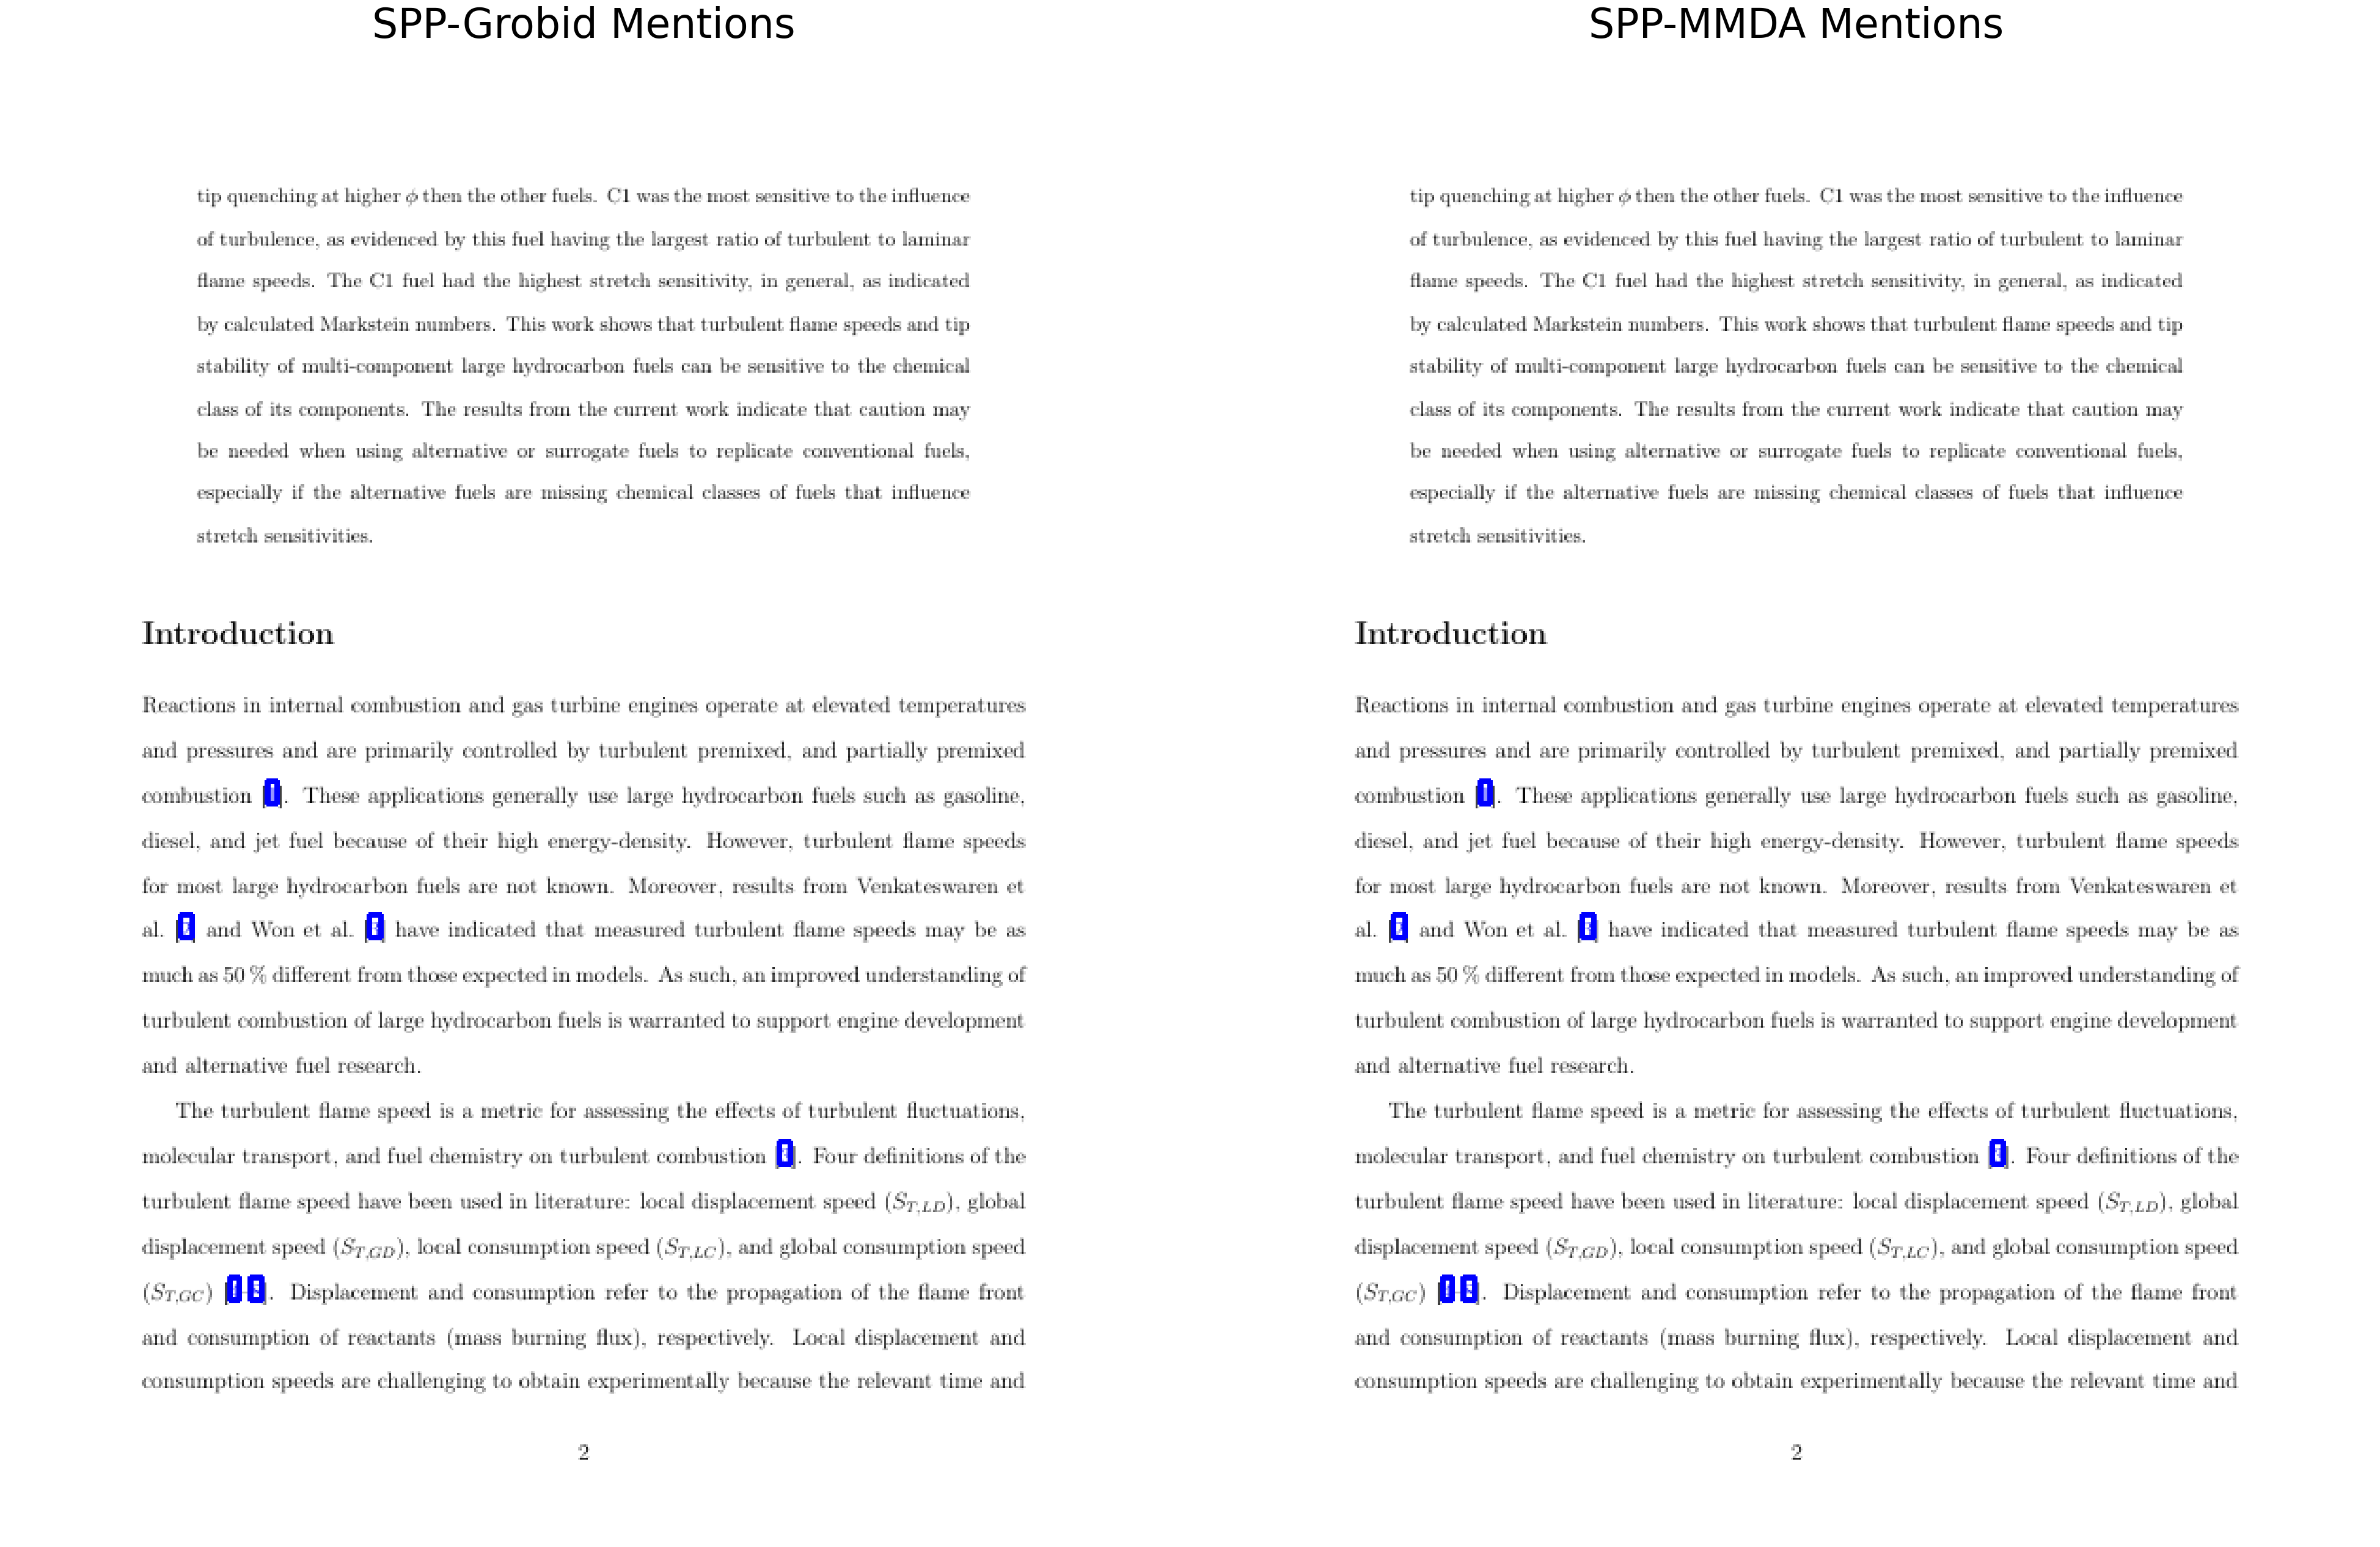

In [60]:
# mentions imgs
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

rows = 1
columns = 2
fontsize = 48

print("annotation page: ", annot_page)

# spp-grobid
#make boxes and save as image
boxes_by_page = make_boxgroups_mentions(spp_grobid_doc)
image1 = draw_boxgroups(spp_grobid_doc.images[annot_page], boxes_by_page[annot_page])

#plot
fig = plt.figure(figsize=(50, 50))
fig.add_subplot(rows, columns, 1)
plt.axis('off')
plt.title("SPP-Grobid Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image1)


#plot side by side
fig.add_subplot(rows, columns, 2)
plt.axis('off')
plt.title("SPP-MMDA Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image1)
plt.subplots_adjust(bottom=0.15, wspace=0.05)


In [61]:
# View all mentions
# uncomment below to see all pages that have mentions (not just the selected annotation page)

# print("annotation page: ", annot_page)

# for page in boxes_by_page:
#     print(f"page {page}:")
#     display(draw_boxgroups(spp_grobid_doc.images[page], boxes_by_page[page]))

In [89]:
def draw_text_blocks(page, text_blocks_dictionary, color_map=None, id_map=None):
    image = spp_grobid_doc.images[page]

    if color_map is None:
        color_map={'relevant': 'blue', 'other': '#f7ede2'}

    if image:
        return lpv.draw_box(image,
                            text_blocks_dictionary[page],
                            color_map=color_map,
                            show_element_id=True,
                            id_font_size=10,
                            id_text_color='blue'
                            )
    
    return None

#function to create labeled text blocks from bibs on the mmda doc
def make_text_blocks_bibs(mmda_doc, relevant_bib_entry_ids):

    result_text_blocks_by_page = defaultdict(list)
    original_boxes_by_page = defaultdict(list)
    page_sizes = dict()
    
    for bib in mmda_doc.bib_entries:
        for box in bib.box_group.boxes:
            if box.page not in page_sizes:
                page_sizes[box.page] = mmda_doc.images[page].size
            page_w, page_h = page_sizes[box.page]

            color = 'relevant' if bib.id in relevant_bib_entry_ids else 'other'

            rect = lpe.Rectangle(
                    box.l * page_w,
                    box.t * page_h,
                    (box.l + box.w) * page_w,
                    (box.t + box.h) * page_h
                )
            result_text_blocks_by_page[box.page].append(lpe.TextBlock(
                rect,
                id=bib.id,
                type=color
            ))
    return result_text_blocks_by_page



In [90]:
page

28

### Bibs Pages

spp_grobid_bib_pages [23, 24, 25, 26, 27, 28]
spp_mmda_bib_pages   [23, 24, 25, 26, 27, 28]
bib_pages            [23, 24, 25, 26, 27, 28]


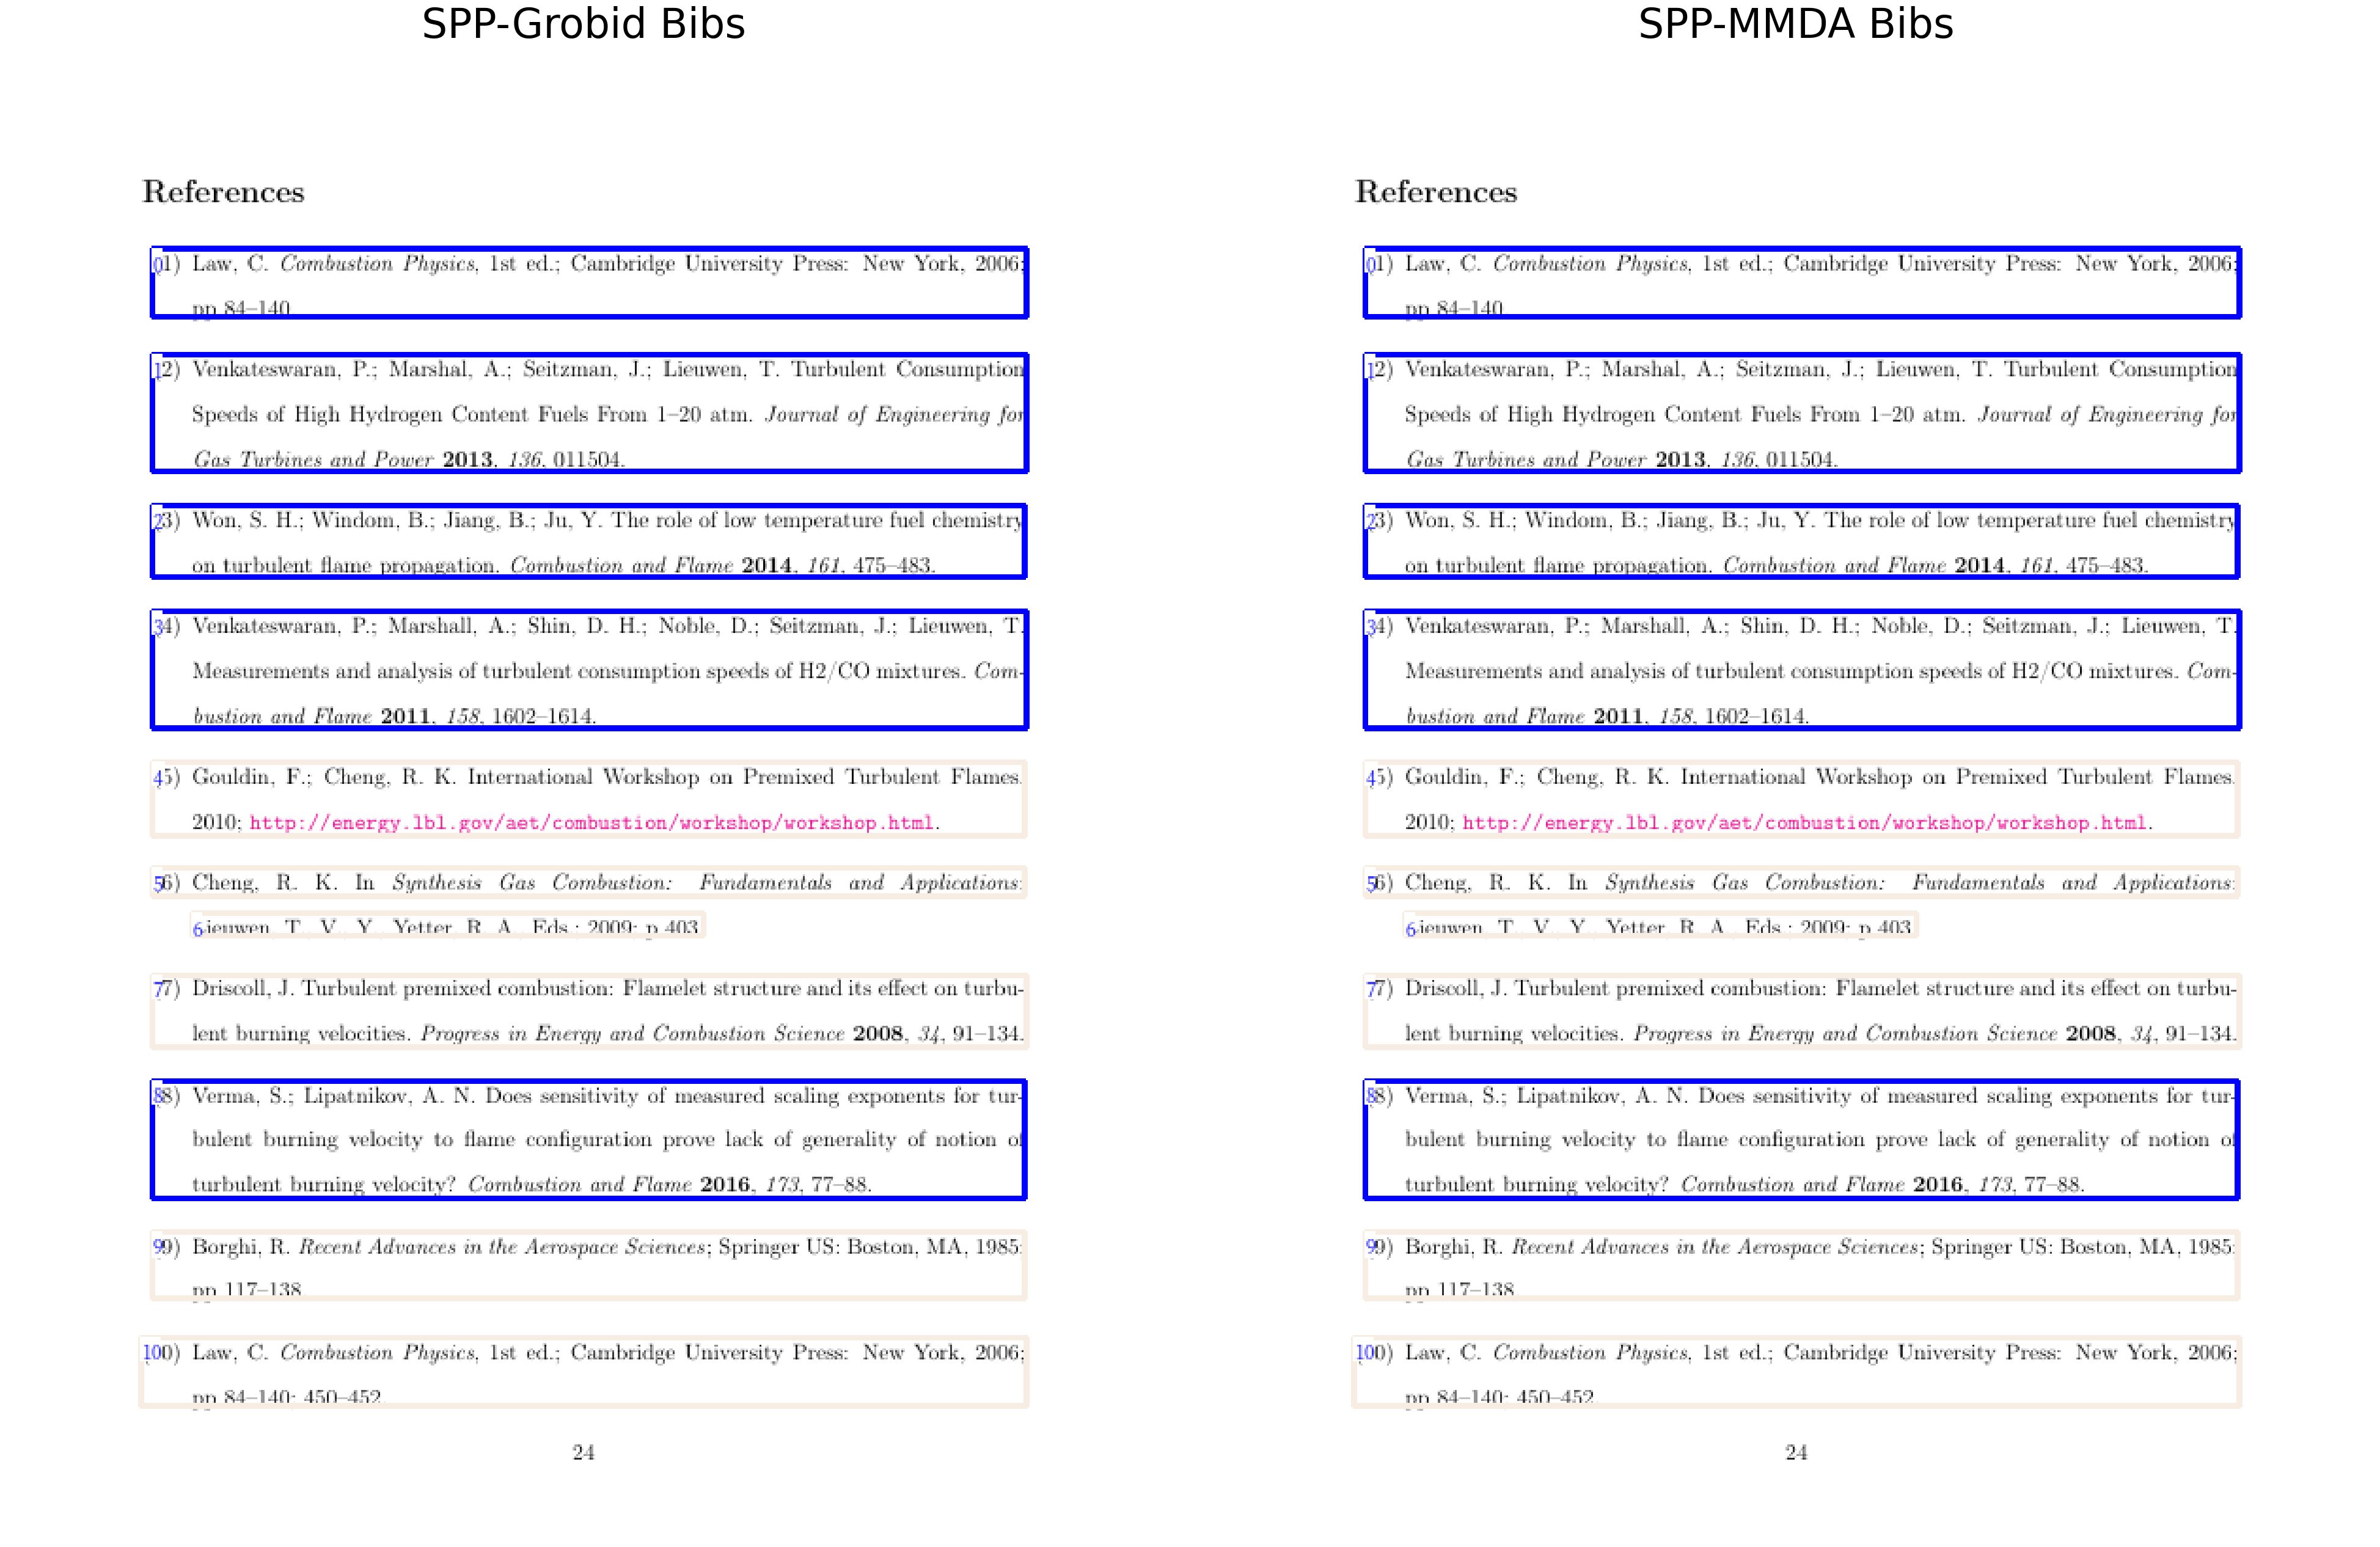

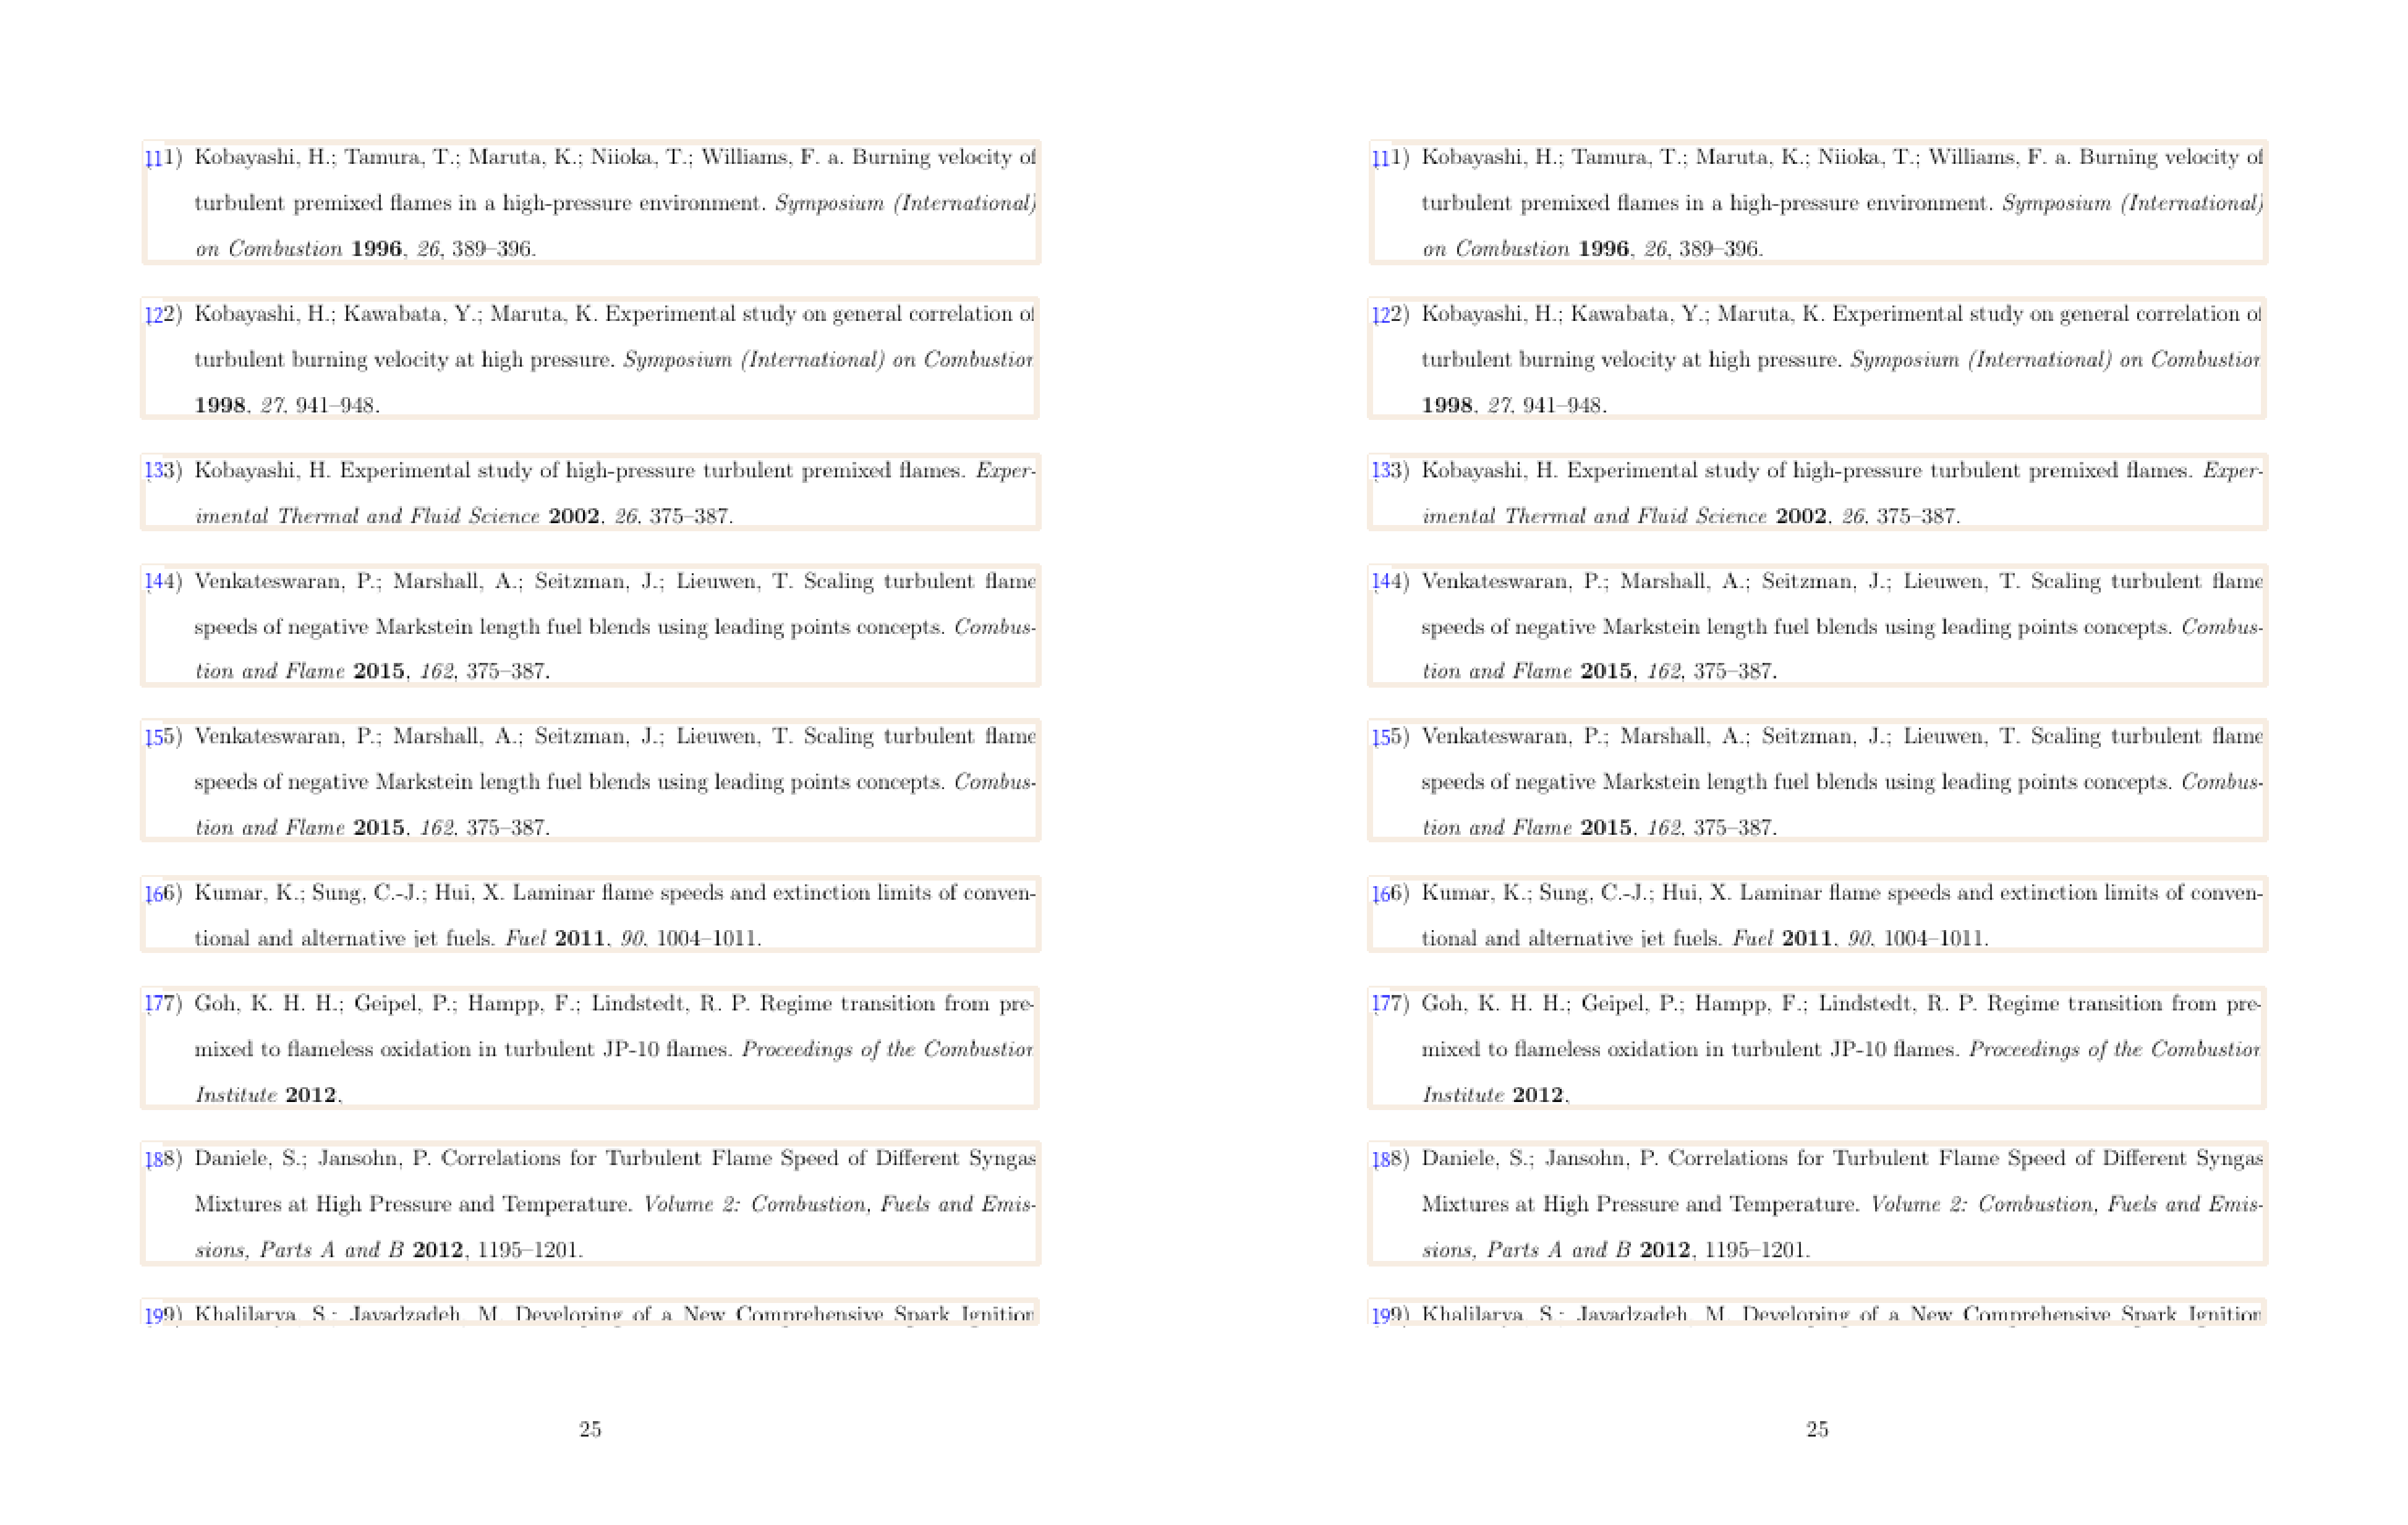

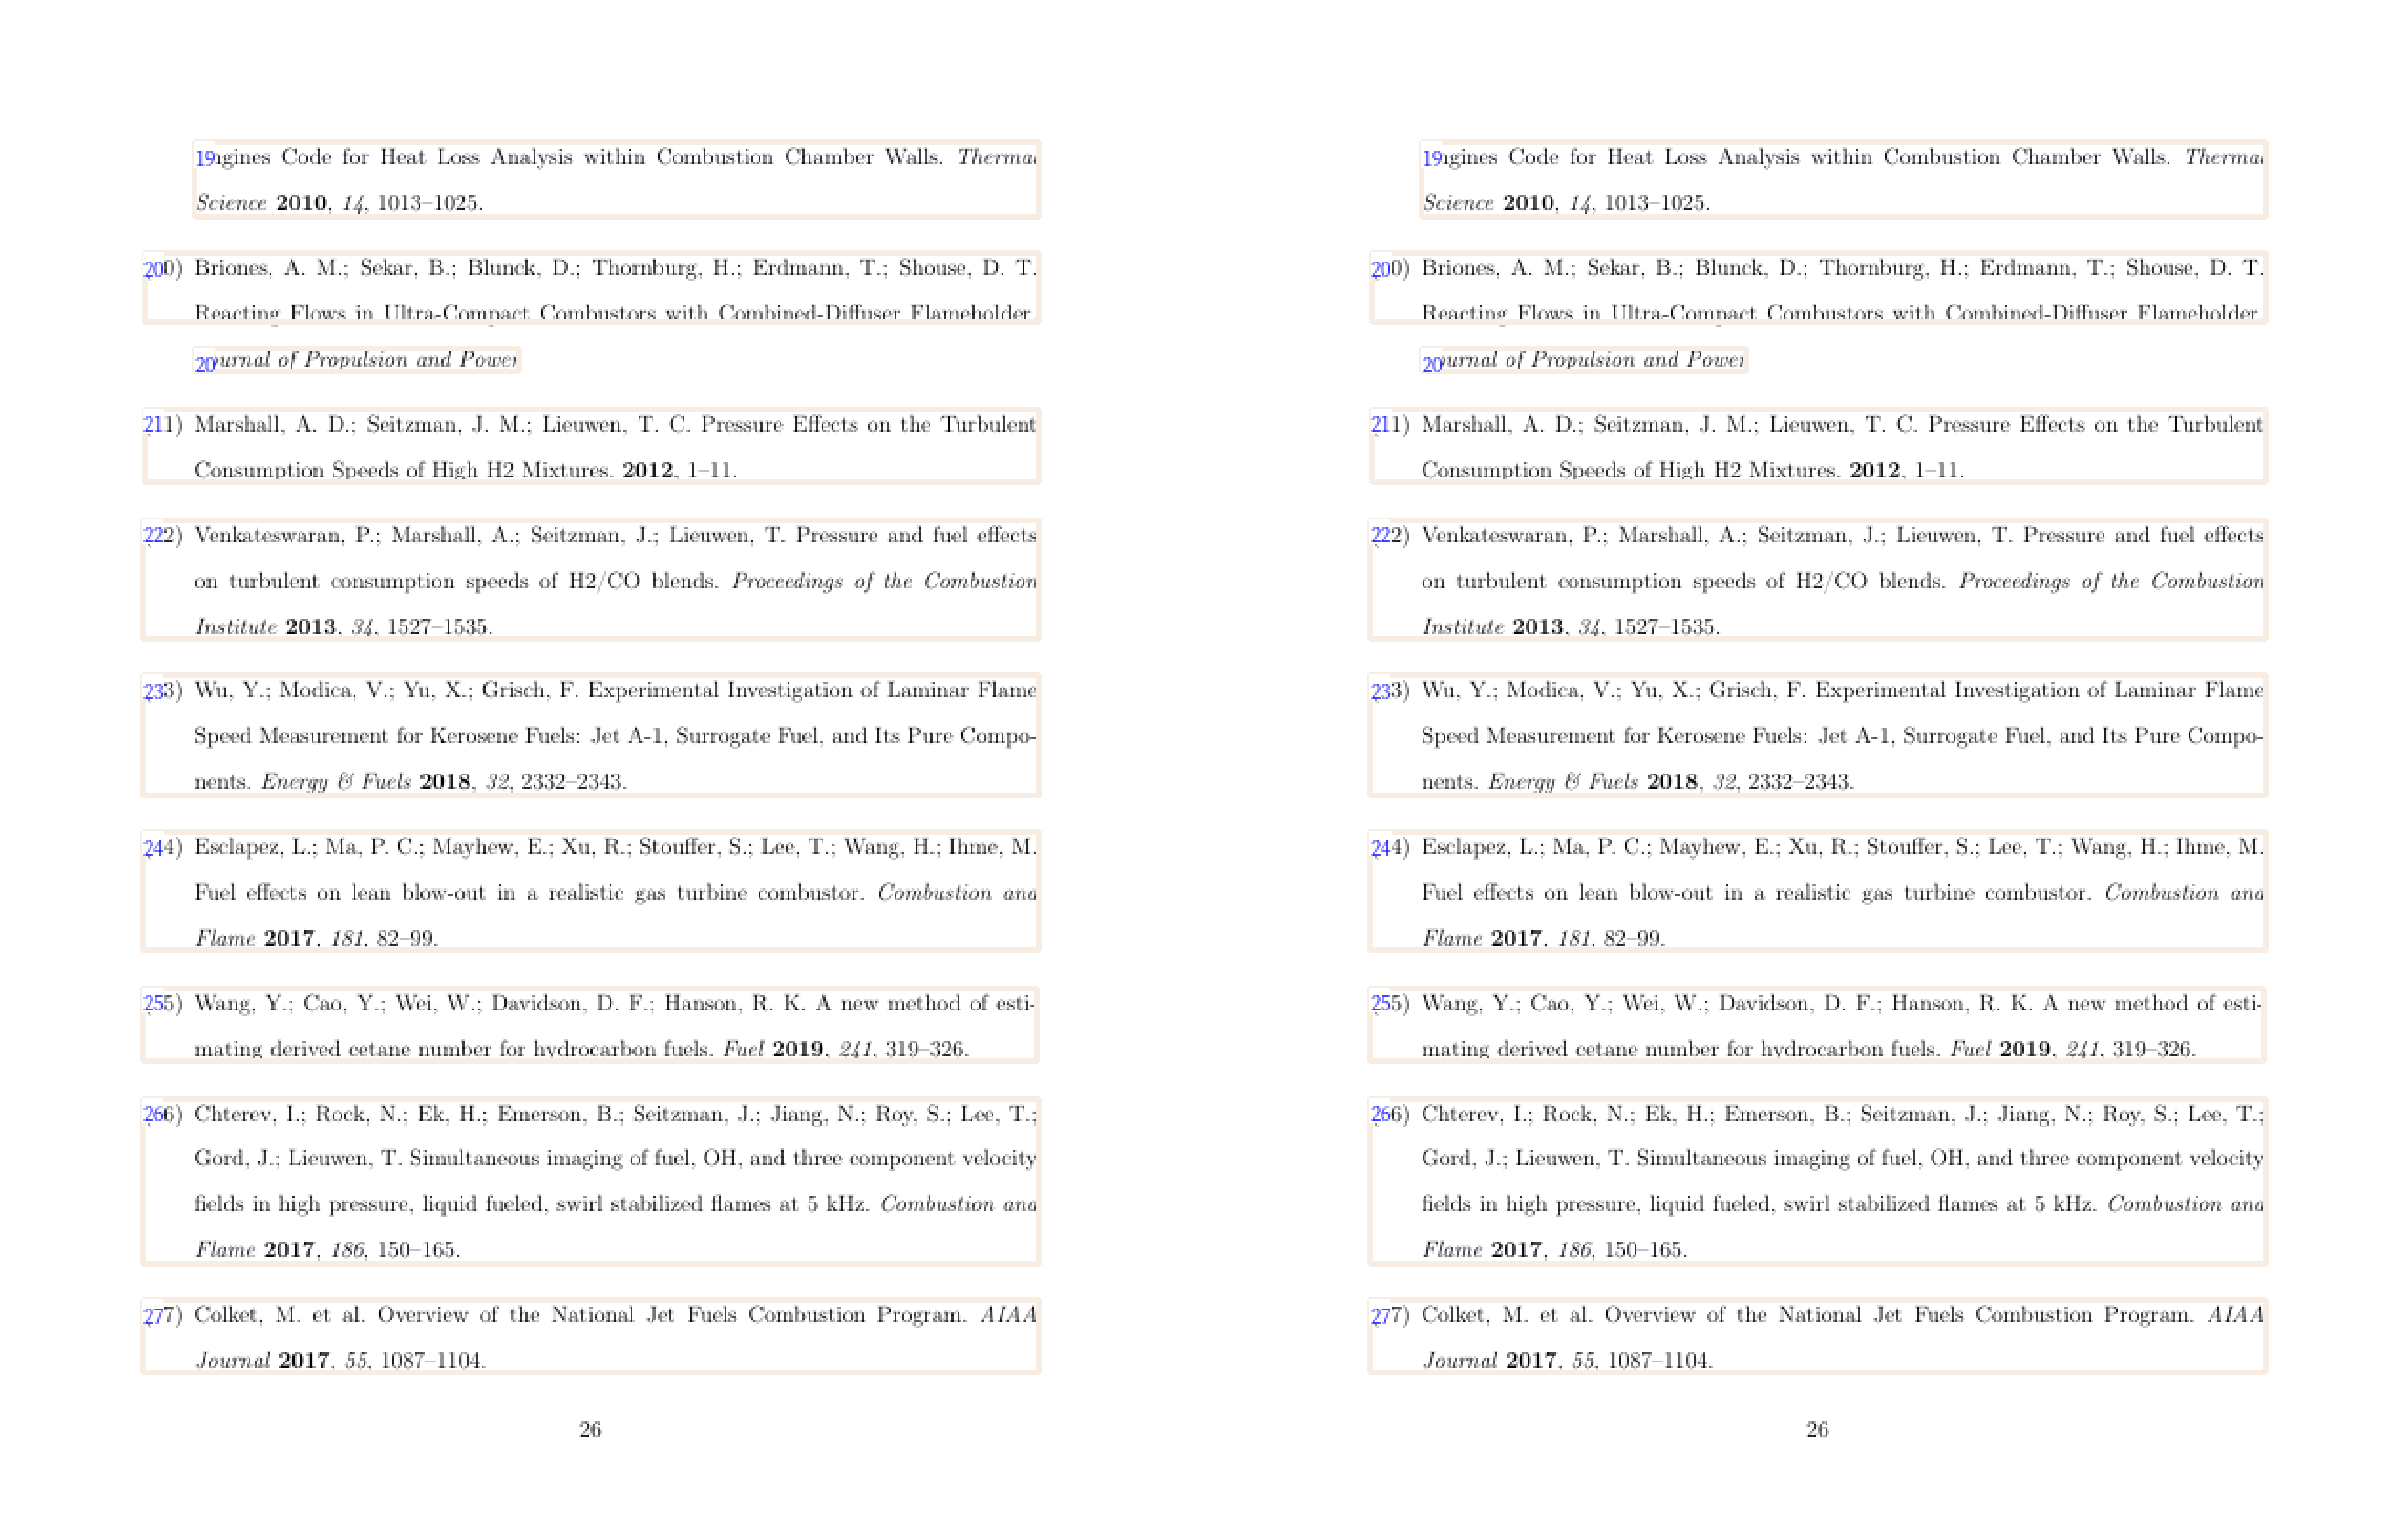

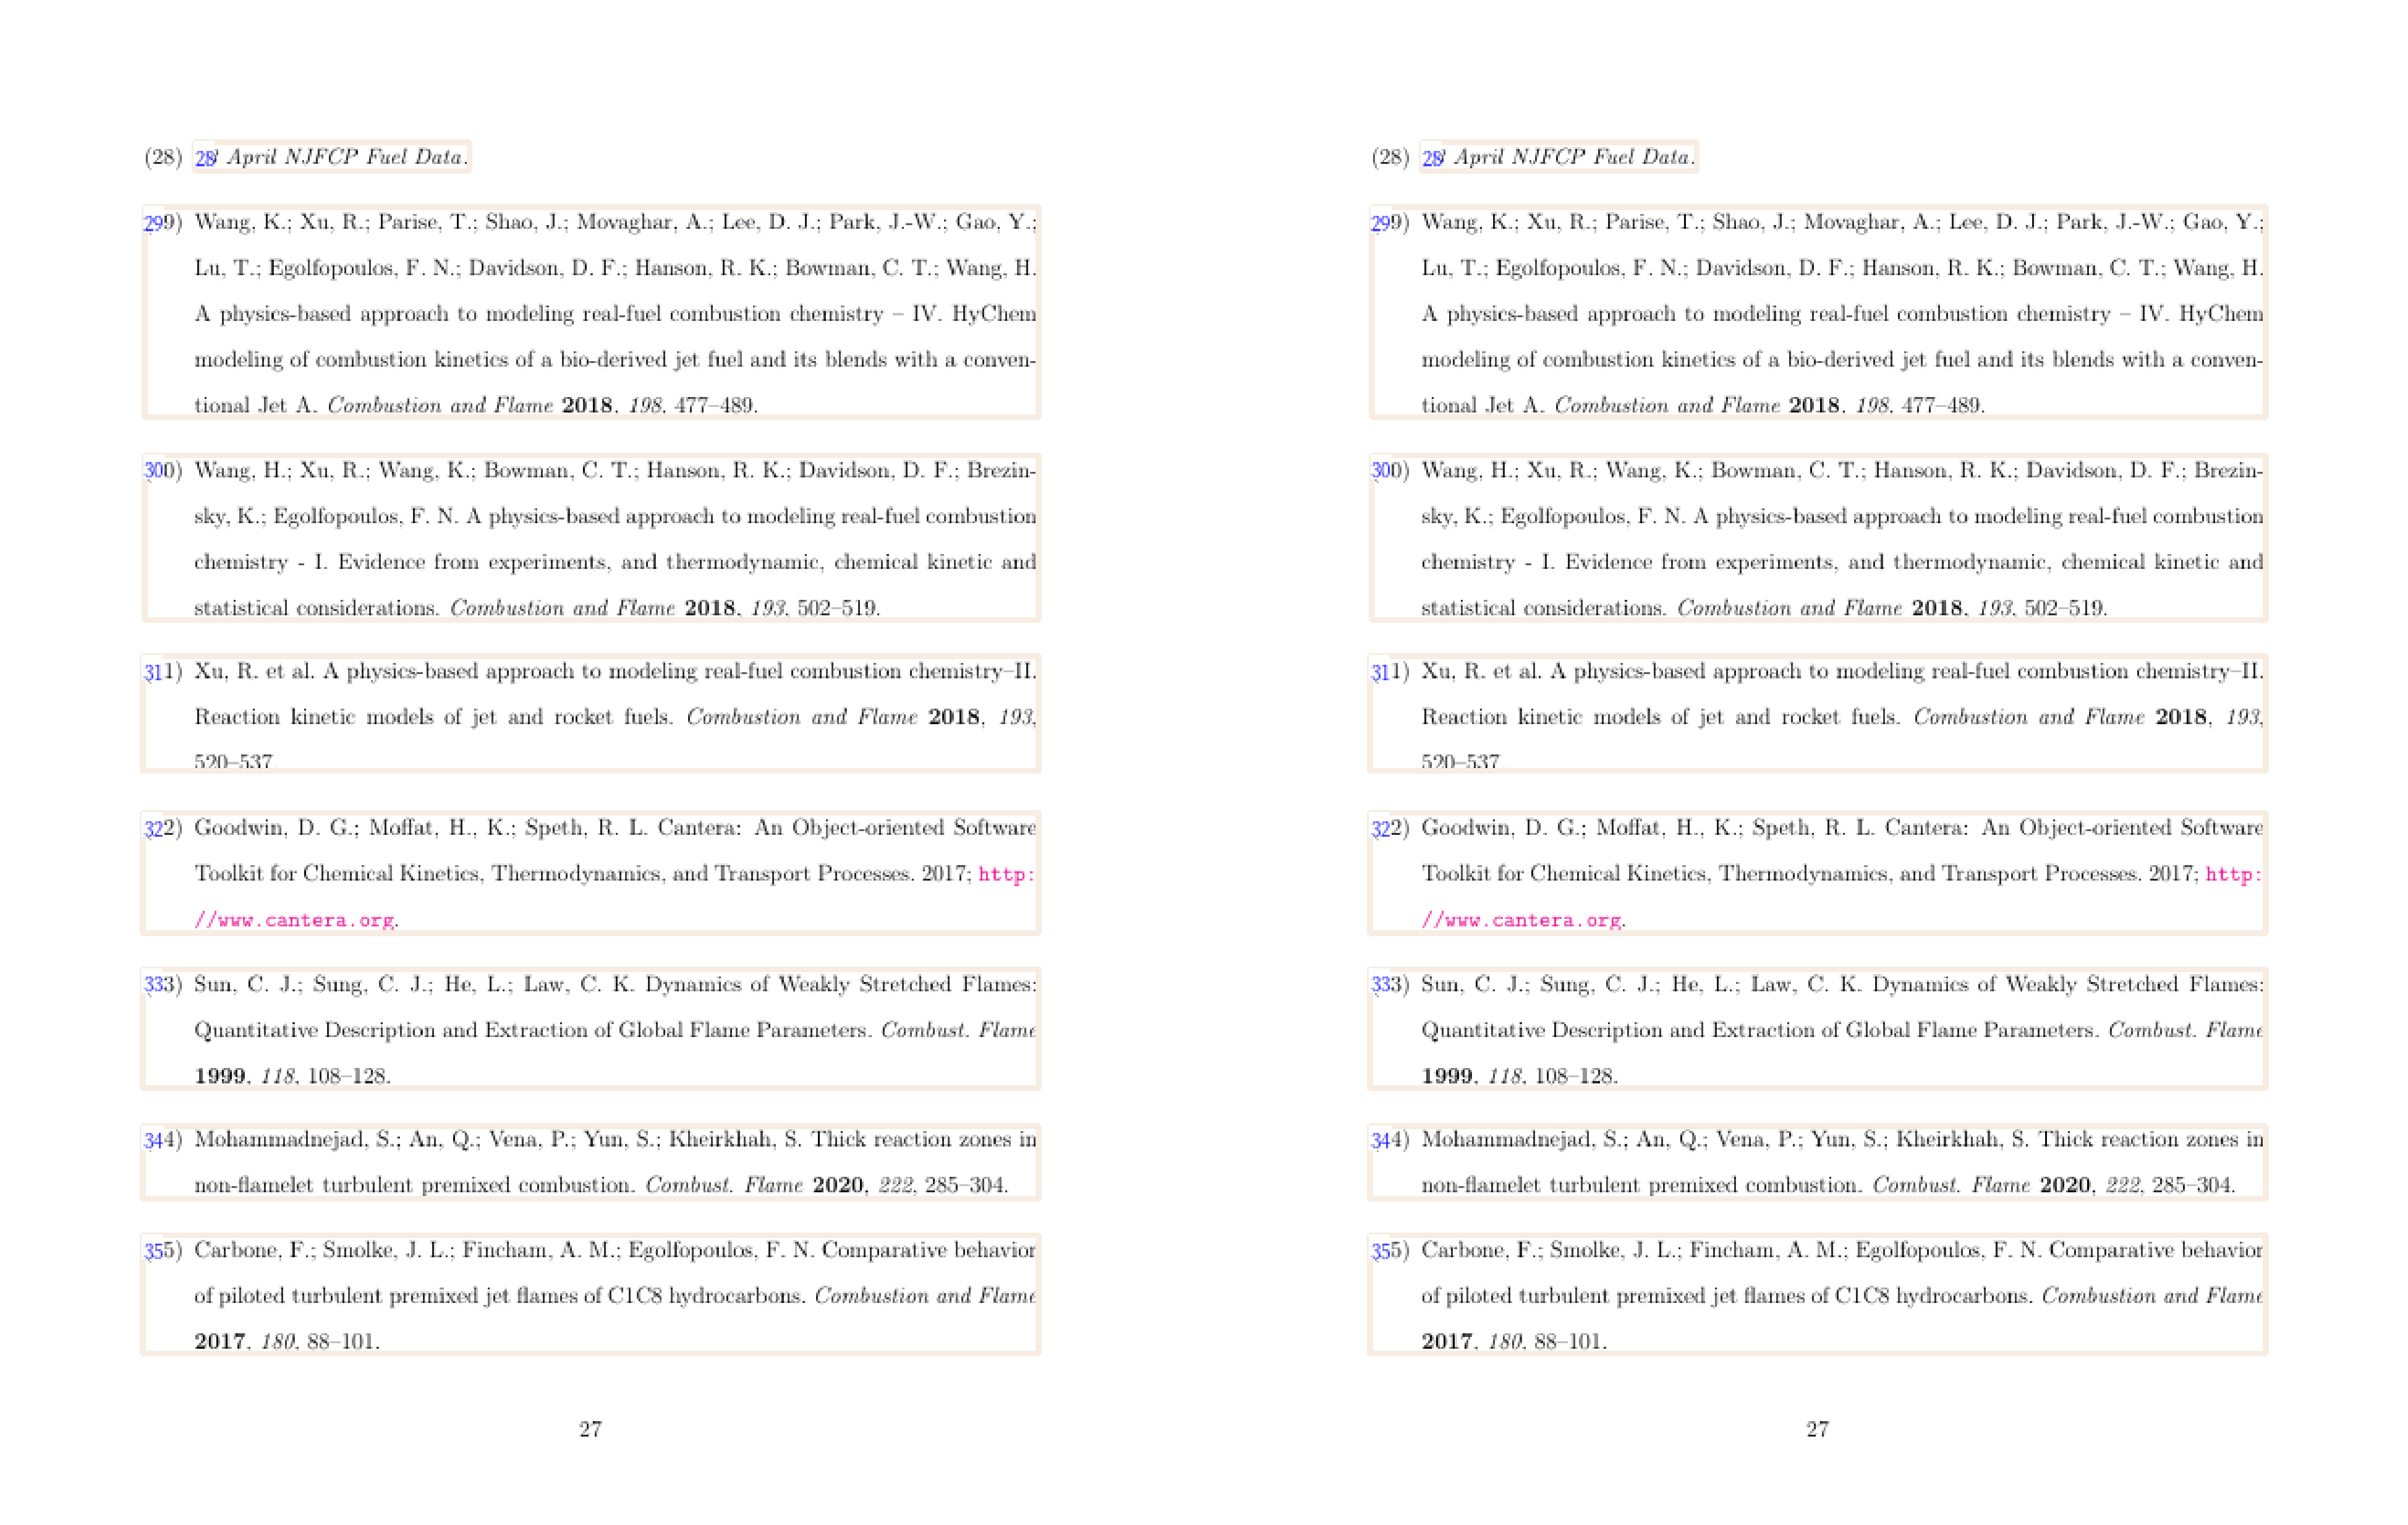

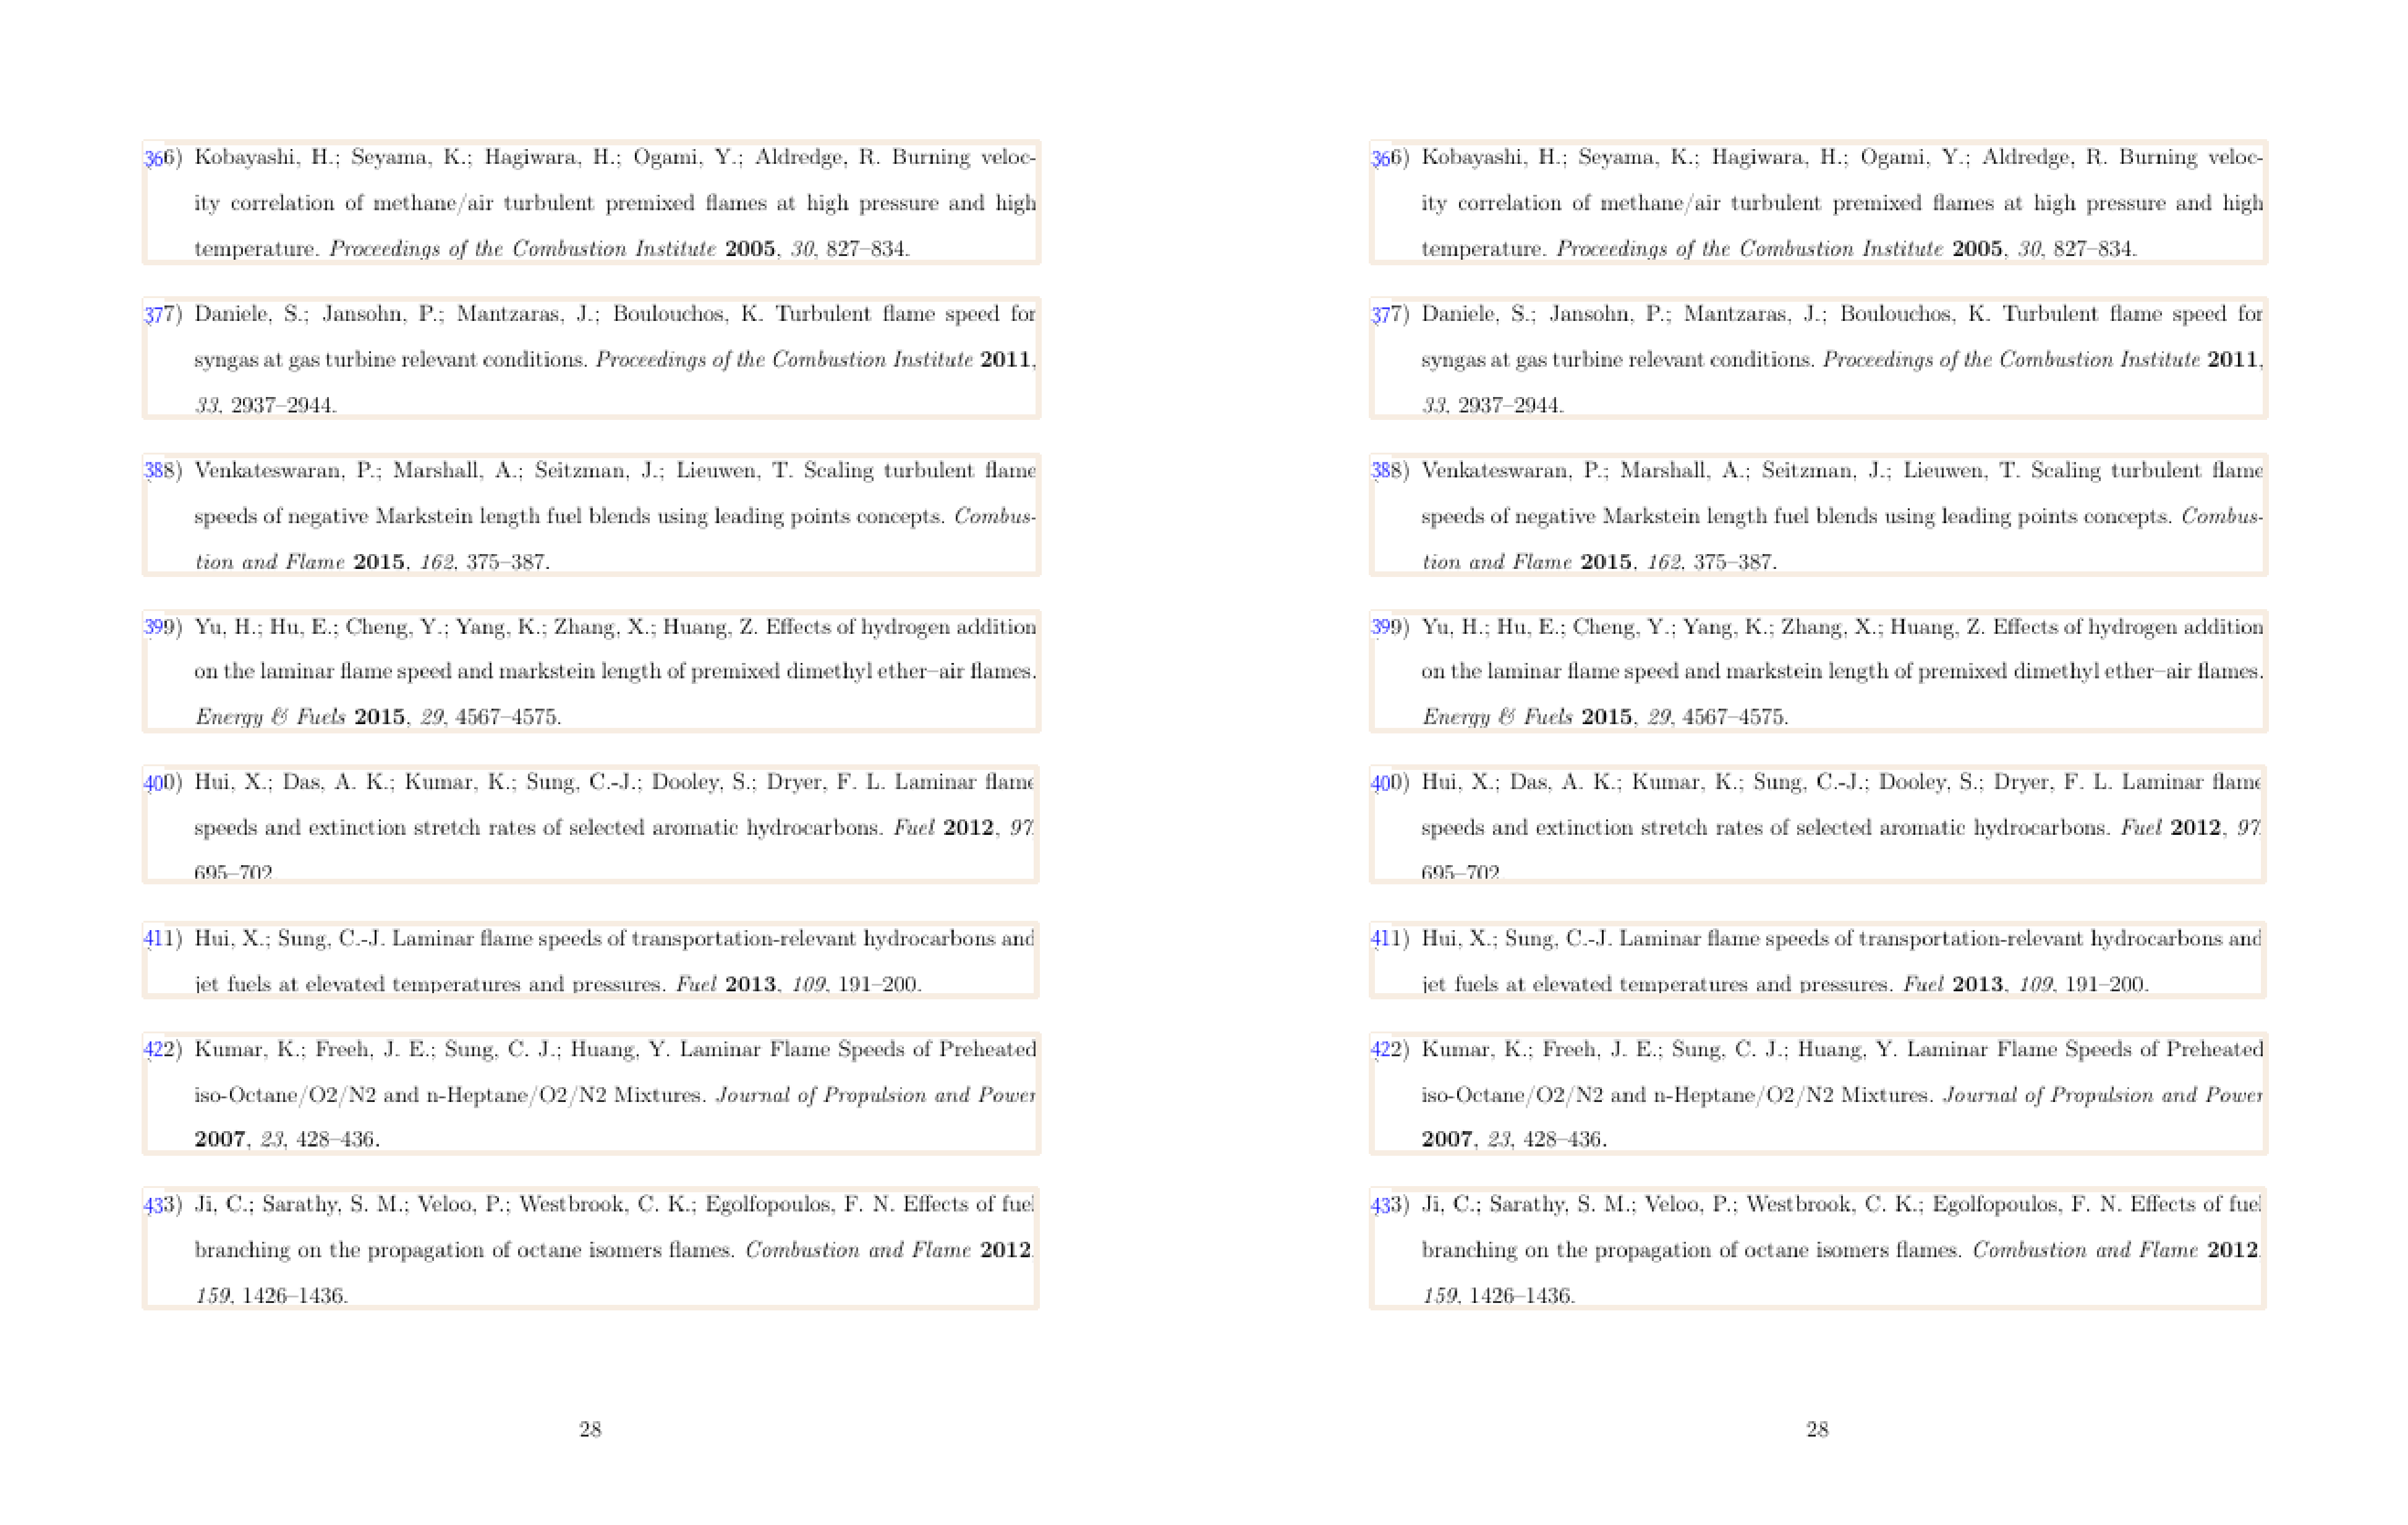

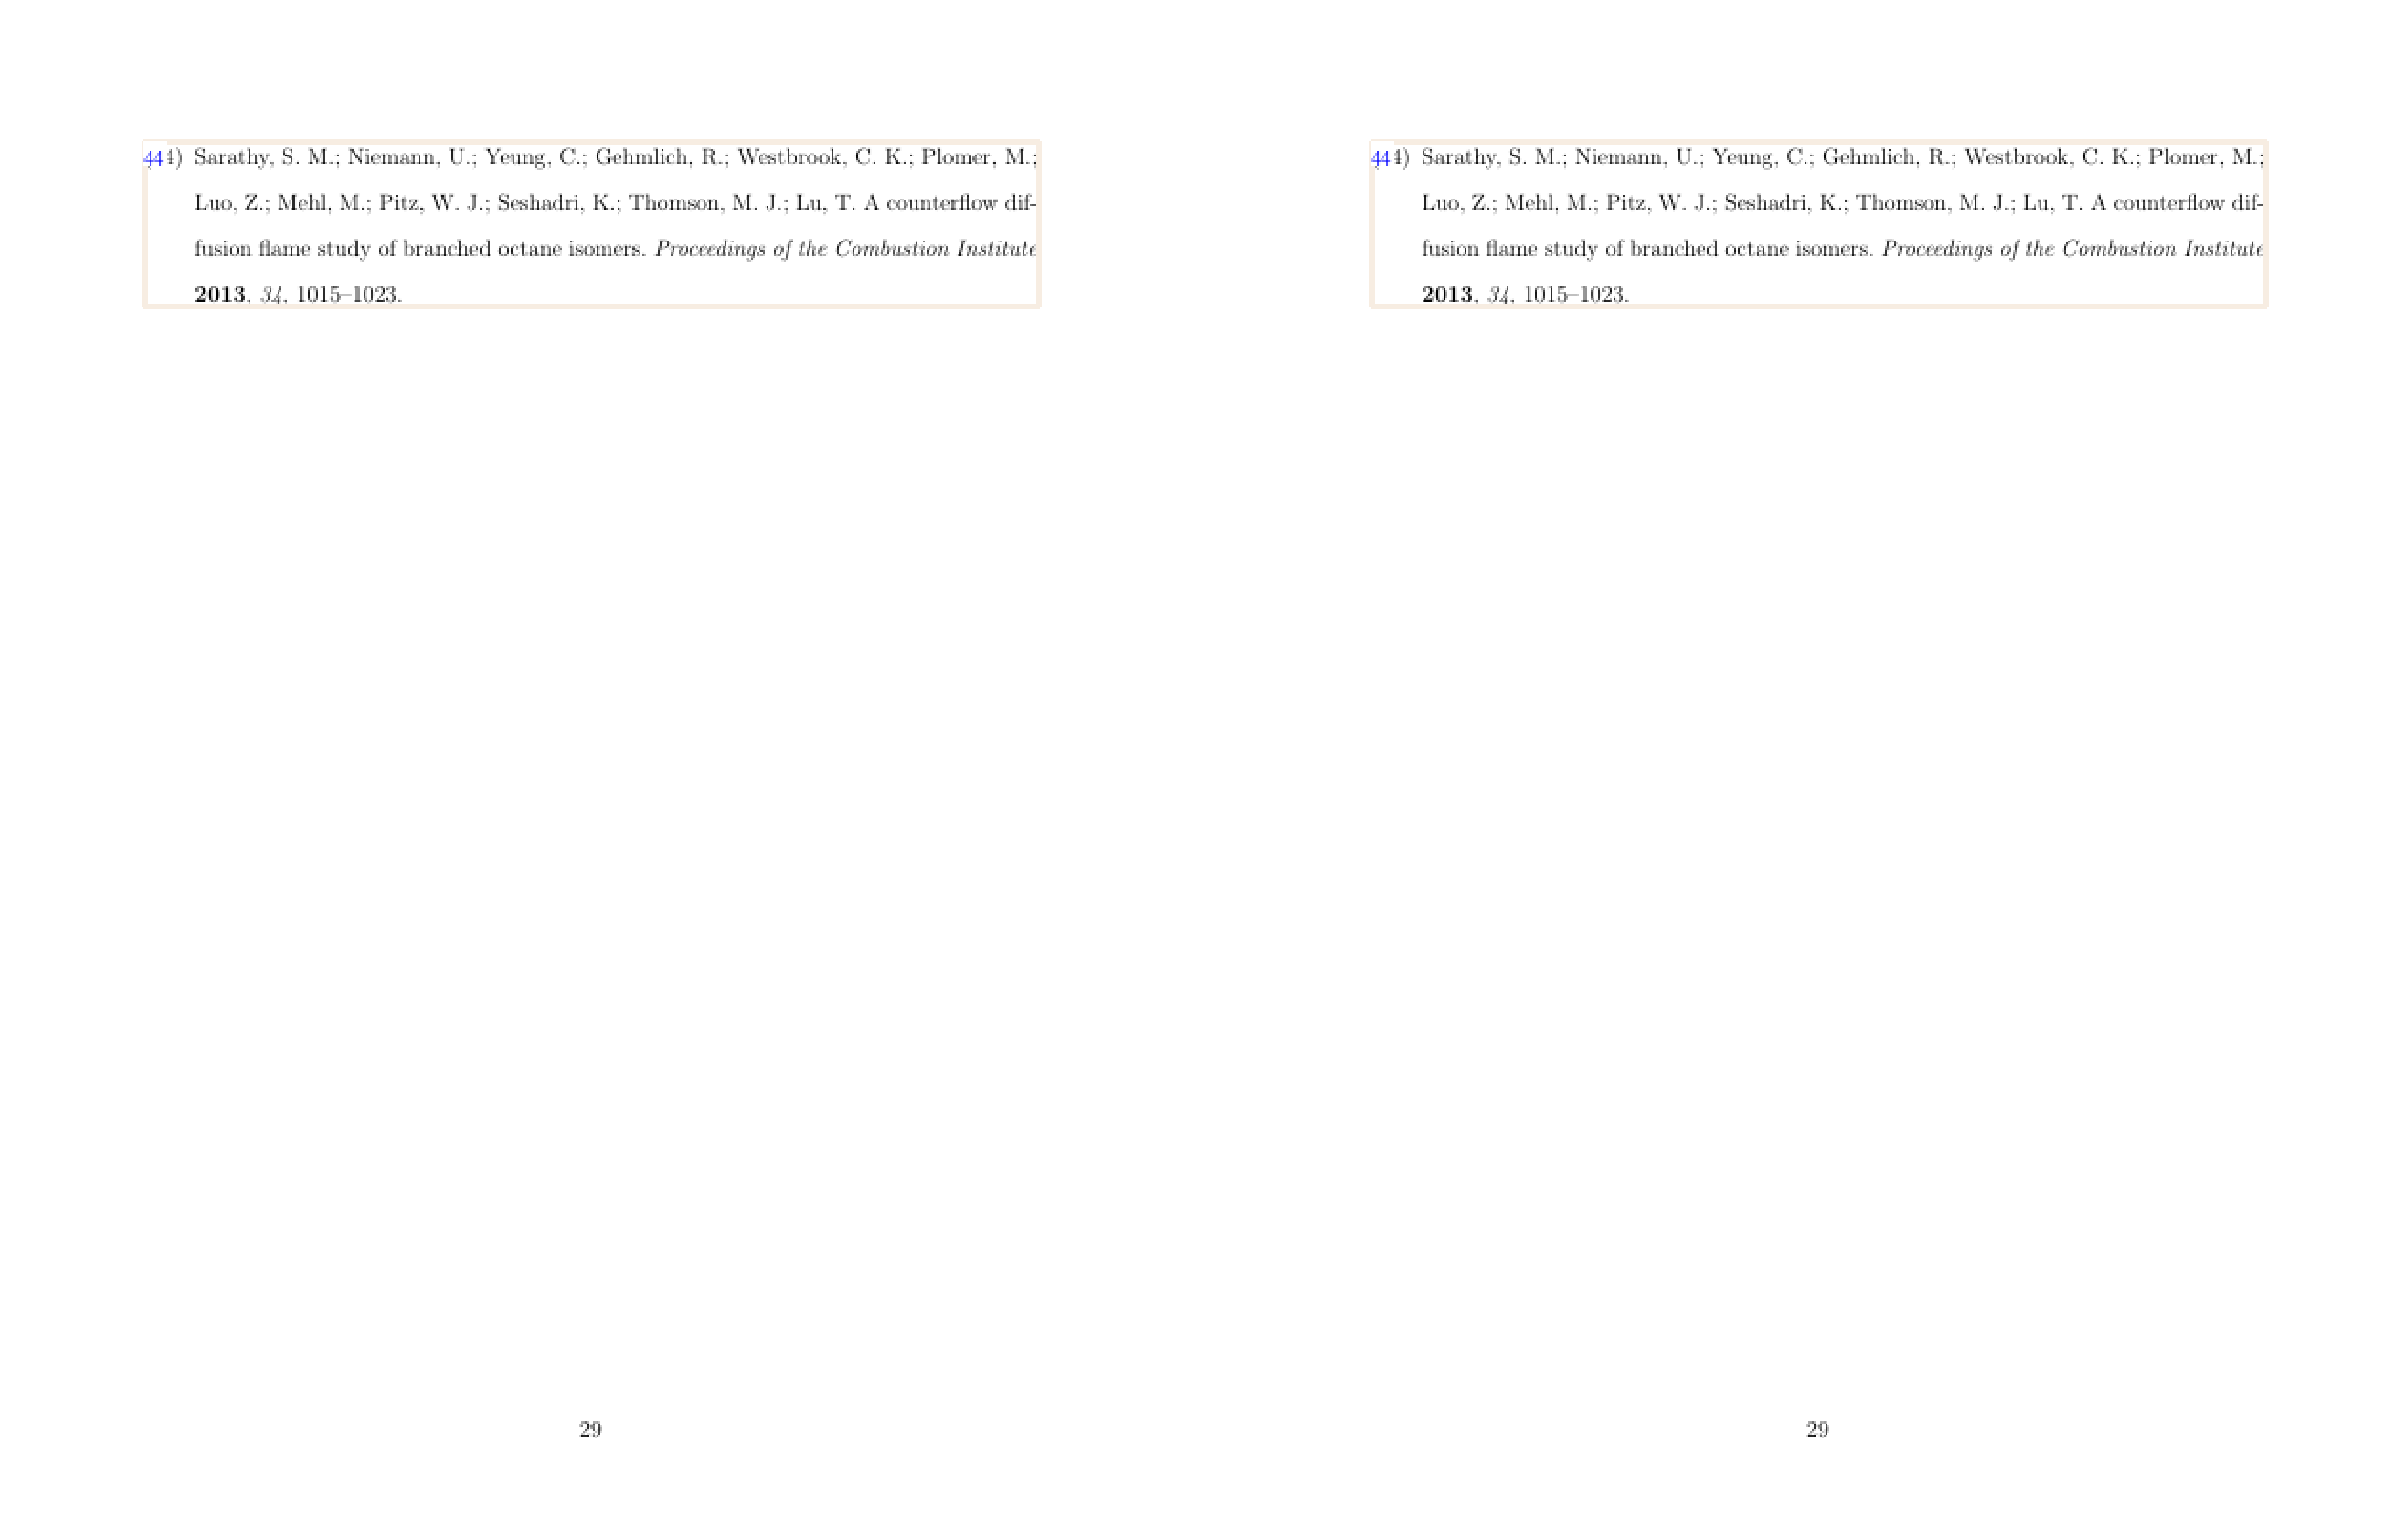

In [91]:
# bibs imgs
spp_grobid_bib_pages = set([bib_entry.box_group.boxes[0].page for bib_entry in spp_grobid_doc.bib_entries])
spp_mmda_bib_pages = set([bib_entry.box_group.boxes[0].page for bib_entry in spp_mmda_doc.bib_entries])
print('spp_grobid_bib_pages', sorted(list(spp_grobid_bib_pages)))
print('spp_mmda_bib_pages  ', sorted(list(spp_mmda_bib_pages)))

bib_pages = spp_grobid_bib_pages.union(spp_mmda_bib_pages)
bib_pages = sorted(list(bib_pages))
print('bib_pages           ', bib_pages)


rows = 1
columns = 2
fontsize = 48


spp_grobid_bib_text_blocks = make_text_blocks_bibs(spp_grobid_doc, relevant_grobid_bibs)
spp_mmda_bib_text_blocks = make_text_blocks_bibs(spp_mmda_doc, relevant_mmda_bibs)


for i, page in enumerate(bib_pages):

    #plot
    fig = plt.figure(figsize=(50, 50))
    fig.add_subplot(rows, columns, 1)
    plt.axis('off')
    if i == 0:
        plt.title("SPP-Grobid Bibs",fontdict={'fontsize': fontsize})
    plt.imshow(draw_text_blocks(page, spp_grobid_bib_text_blocks)) 


    #plot side by side
    fig.add_subplot(rows, columns, 2)
    plt.axis('off')
    if i == 0:
        plt.title("SPP-MMDA Bibs",fontdict={'fontsize': fontsize})
    plt.imshow(draw_text_blocks(page, spp_mmda_bib_text_blocks)) 
    plt.subplots_adjust(bottom=0.15, wspace=0.05)


## ANNOTATOR TODO: 
Record each mention on this page (regardless of if it got recognized by SPP or not) as 1 row in the spreadsheet.